In [2]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics
from copy import copy
from scipy.stats import ks_2samp, mannwhitneyu
import scipy
import cv2
import math
import os.path

In [3]:
time_dome = str(4)
dome_number = str(99)

folder_and_dome = str('./../../../../Desktop/manual_dome'+dome_number+'_tp'+time_dome+'/'+dome_number+'_denoised_tp')

wd = folder_and_dome + time_dome

print(wd)

./../../../../Desktop/manual_dome99_tp4/99_denoised_tp4


In [4]:
image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

manual_top = sk.io.imread(wd+'_manual_top.tif')
manual_top_r = common_functions.get_image_r(manual_top)

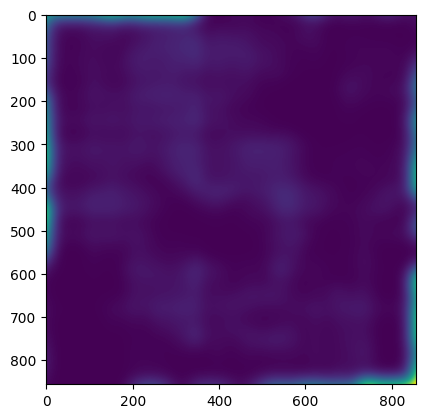

In [8]:
if os.path.isfile(wd+'_gaussian_top.tif'):
    gaussian_top = sk.io.imread(wd+'_gaussian_top.tif')
else:
    gaussian_top = common_functions.get_3D_gaussian(manual_top)
    tiff.imwrite(wd+'_gaussian_top.tif', common_functions.normalize_image(gaussian_top, 255).astype(np.uint8))

gaussian_top_r = common_functions.get_image_r(gaussian_top)
plt.imshow(gaussian_top[400])

In [9]:
epithelial_r = gaussian_top_r*image_r

In [10]:
def find_maximus(epithelial, moveLine, margin=5):

    max_intensity_indices =  np.argmax(epithelial, axis=0)

    apical = np.zeros(epithelial.shape)
    apical[max_intensity_indices, np.array(list(range(epithelial.shape[1])))] = 1

    # print(-moveLine-margin)

    if moveLine-margin > 0:
        apical[-moveLine-margin:, :] = 0

    return apical

def gamma_correction(image, gamma):

    current_max = image.max()

    image = common_functions.normalize_image(image,1)

    image = image**gamma

    image = common_functions.normalize_image(image, current_max)

    return image


def mid_gamma_correction(image, mid=0.8):
    mean = np.mean(image)
    meanLog = math.log(mean)
    midLog = math.log(mid*255)
    gamma =midLog/meanLog
    gamma = 1 / gamma
    # print(gamma)

    return gamma_correction(image, gamma)

def find_first_last_nonzero(arr):
    non_zero_indices = np.nonzero(arr)[0]
    if non_zero_indices.size == 0:
        return None, None
    first_nonzero = arr[non_zero_indices[0]]
    last_nonzero = arr[non_zero_indices[-1]]
    return first_nonzero, last_nonzero

def find_first_last_nonzero_indices(arr):
    non_zero_indices = np.nonzero(arr)[0]
    if non_zero_indices.size == 0:
        return None, None
    first_nonzero_index = non_zero_indices[0]
    last_nonzero_index = non_zero_indices[-1]
    return first_nonzero_index, last_nonzero_index

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

def fucking_apical(image, gaussian, angles, moveLines, margin_cut = 5, plots=False):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    total_apical = np.zeros(image.shape)
    image = mid_gamma_correction(image)
    apical_i = np.zeros((len(moveLines), image.shape[0], image.shape[1]))

    for angle in angles:
        # Rotate image and Gaussian
        rot_image = rotate(image, angle, reshape=False)

        if margin_cut > 0:
            rot_image[rot_image.shape[0]-3*int(margin_cut/4):rot_image.shape[0]-2*int(margin_cut/4), :] = rot_image.max()/2

        rot_gaussian = rotate(gaussian, angle, reshape=True)
        
        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        for m, moveLine in enumerate(moveLines):
            # Move Gaussian and crop to match the image shape
            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            y_0 = (rot_gaussian.shape[0] - image.shape[0]) // 2
            y_1 = y_0 + image.shape[0]
            x_0 = (rot_gaussian.shape[1] - image.shape[1]) // 2
            x_1 = x_0 + image.shape[1]
            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            # Calculate rotated epithelial
            rot_epithelial = rot_image * rot_gaussian_up
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, margin=0)
            apical_i[m] = apical_rot_ml

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]
                if np.sum(column) > 0:

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    first_nonzero_gaus, last_nonzero_gaus = find_first_last_nonzero_indices(gaussian_distribution)
                    rot_epithelial_norm_array = gaussian_distribution[first_nonzero_gaus:last_nonzero_gaus]
                    rot_gaussian_norm_array = epithelial_distribution[first_nonzero_gaus:last_nonzero_gaus]

                    distance = jensen_shannon_distance(rot_epithelial_norm_array, rot_gaussian_norm_array)

                    p_values_ml[m, x] = distance

            if plots:
                plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml, margin_cut)

        #### test 1: filter by mean ####
        # mean_p_values = p_values_ml.mean(axis=0, keepdims=True)
        # p_values_ml = np.where(p_values_ml > mean_p_values, True, False)
        ####

        #### test 2: just keep the maximum value ####
        min_values_per_column = np.max(p_values_ml, axis=0)
        p_values_ml = np.where(p_values_ml == min_values_per_column, True, False)
        ####
        
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        apical_i[mask_expanded == False] = 0

        # Sum across all layers
        summed_apical_i = np.sum(apical_i, axis=0)

        summed_apical_i[-margin_cut:] = 0

        if plots:
            plt.figure()
            plt.imshow(summed_apical_i) 
            plt.show()
        
        # Rotate back and add to total_apical
        apical = rotate(summed_apical_i, -angle, reshape=False)
        total_apical += apical


    return total_apical

def plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml, margin_cut):
    cols = 5
    rows = 1
    evaluate = 150  # This can be adjusted based on your specific needs

    max_found = np.argmax(rot_epithelial[:, evaluate])

    plt.figure(figsize=(30, 3))
    plt.subplot(rows, cols, 1)
    plt.title(f'Angle {angle}')
    plt.imshow(rot_image)
    plt.subplot(rows, cols, 2)
    plt.title(f'MoveLine {moveLine}')
    plt.axvline(evaluate)
    plt.axhline(max_found)
    plt.imshow(rot_epithelial)
    plt.subplot(rows, cols, 3)

    

    rot_epithelial_norm_array = common_functions.normalize_image(rot_epithelial[:, evaluate], 1)
    rot_gaussian_norm_array = common_functions.normalize_image(rot_gaussian_up[:, evaluate], 1)

    # first_nonzero_ep, last_nonzero_ep = find_first_last_nonzero_indices(rot_epithelial_norm_array)
    first_nonzero_gaus, last_nonzero_gaus = find_first_last_nonzero_indices(rot_gaussian_norm_array)

    rot_epithelial_norm_array = rot_epithelial_norm_array[first_nonzero_gaus:last_nonzero_gaus]
    rot_gaussian_norm_array = rot_gaussian_norm_array[first_nonzero_gaus:last_nonzero_gaus]

    # ks_stat, p_value = ks_2samp(rot_epithelial_norm_array,
    #                             rot_gaussian_norm_array)
    # print(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    # plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    distance = jensen_shannon_distance(rot_epithelial_norm_array, rot_gaussian_norm_array)
    
    plt.title(f'col {evaluate}, {distance:.3f}, max at {max_found}')
    plt.plot(rot_gaussian_norm_array, label='Gaussian')
    plt.plot(rot_epithelial_norm_array, label='Epithelial')
    plt.legend()
    plt.subplot(rows, cols, 4)
    apical_rot_ml[-margin_cut:] = 0
    plt.imshow(apical_rot_ml)
    plt.subplot(rows, cols, 5)
    plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
    plt.show()


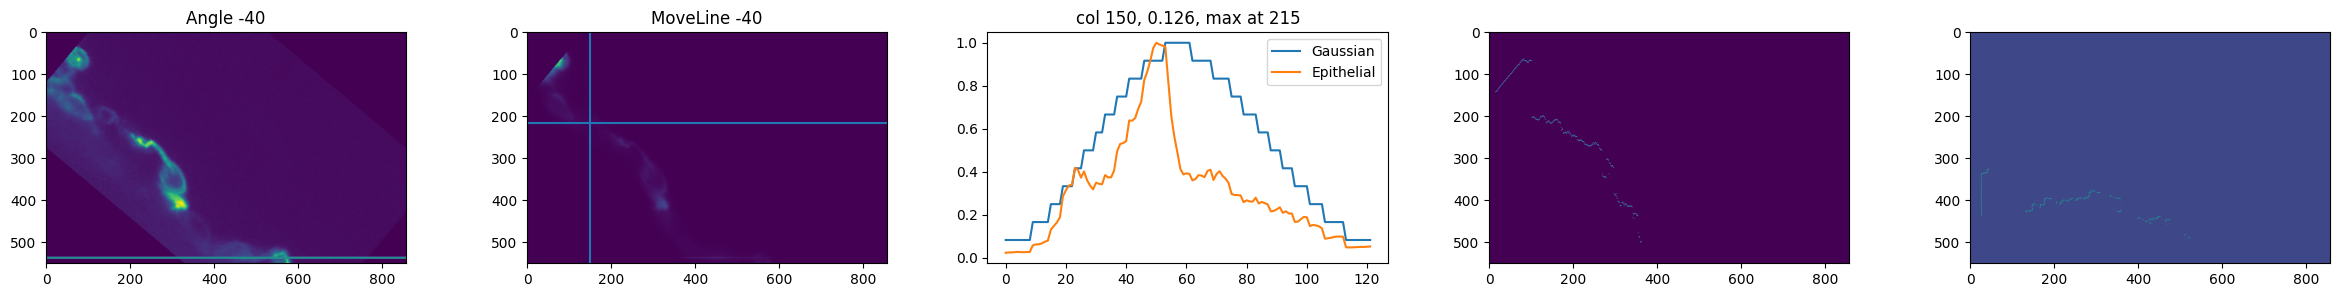

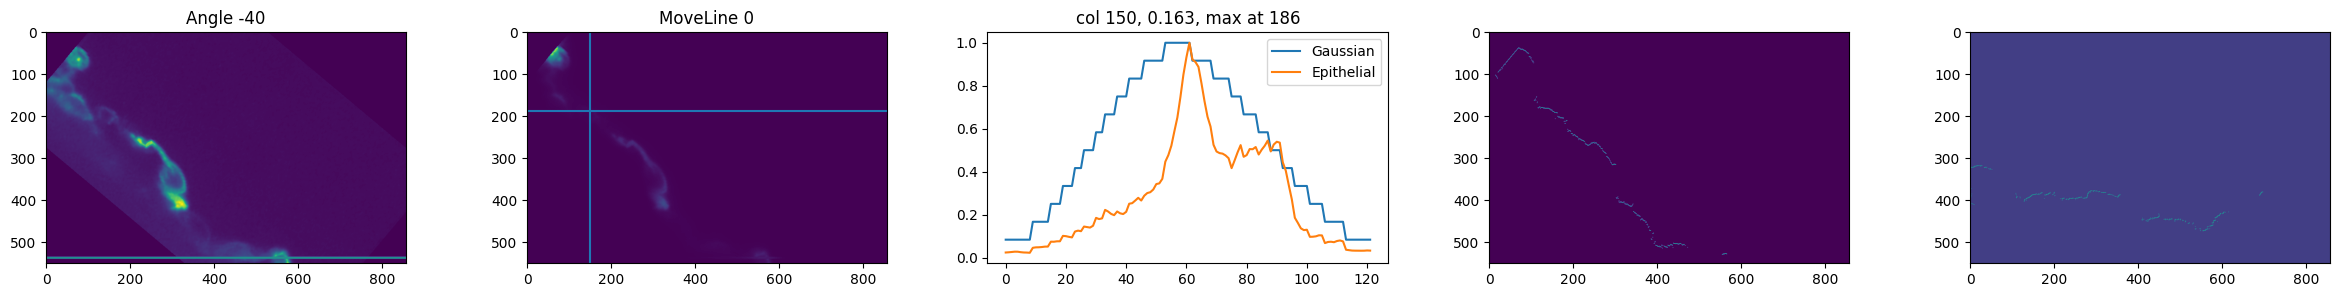

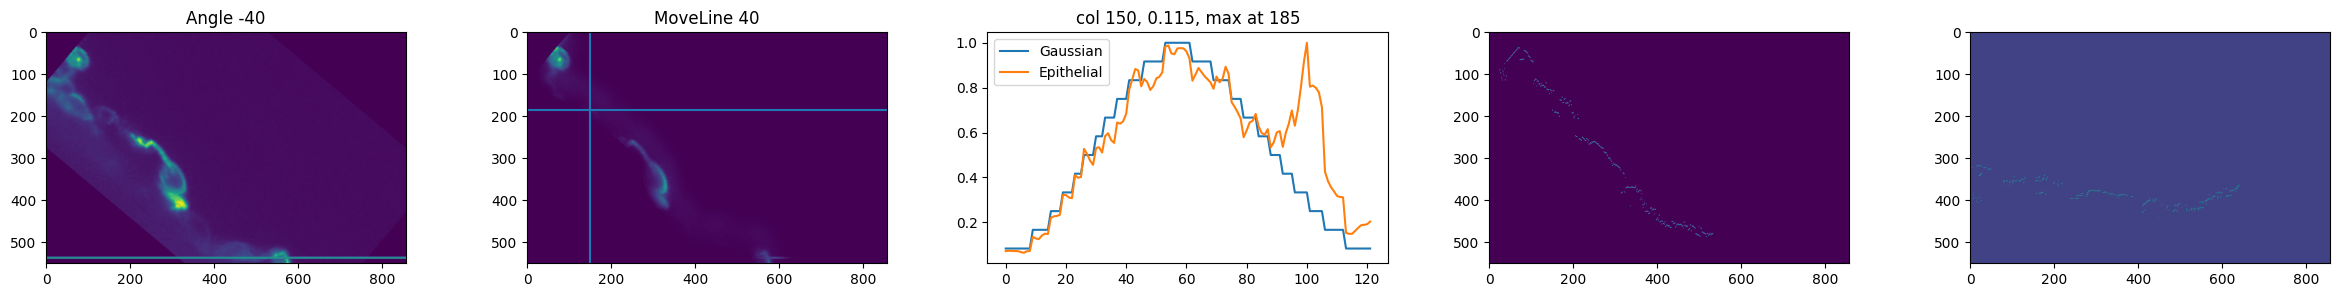

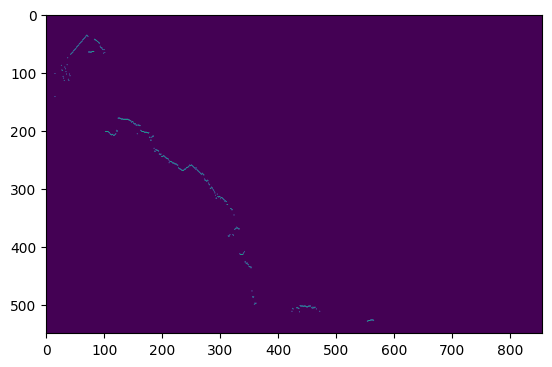

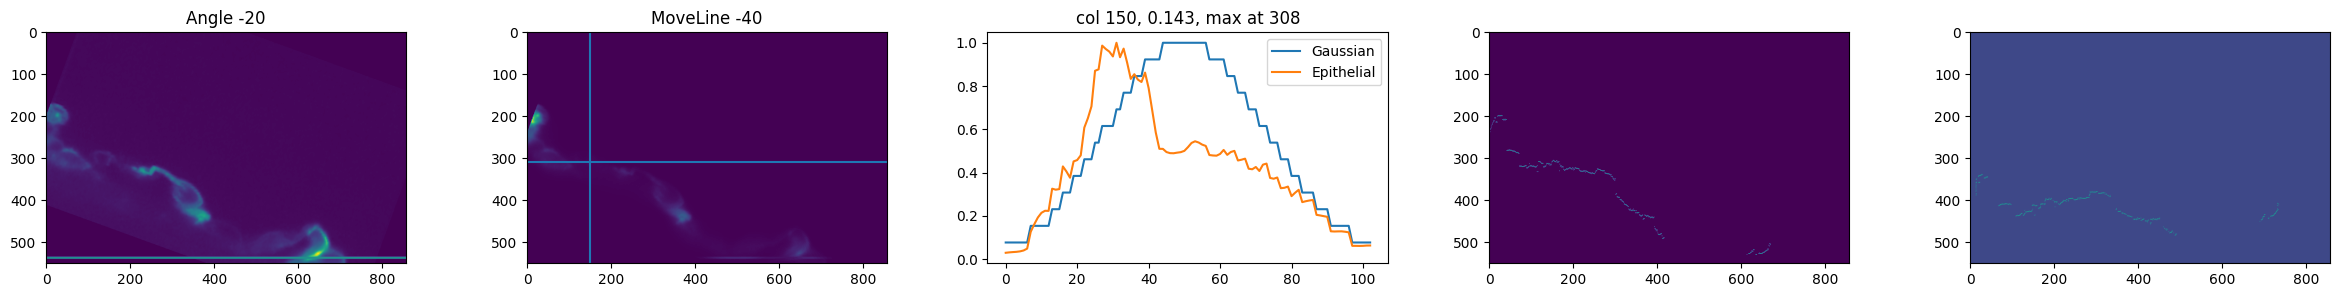

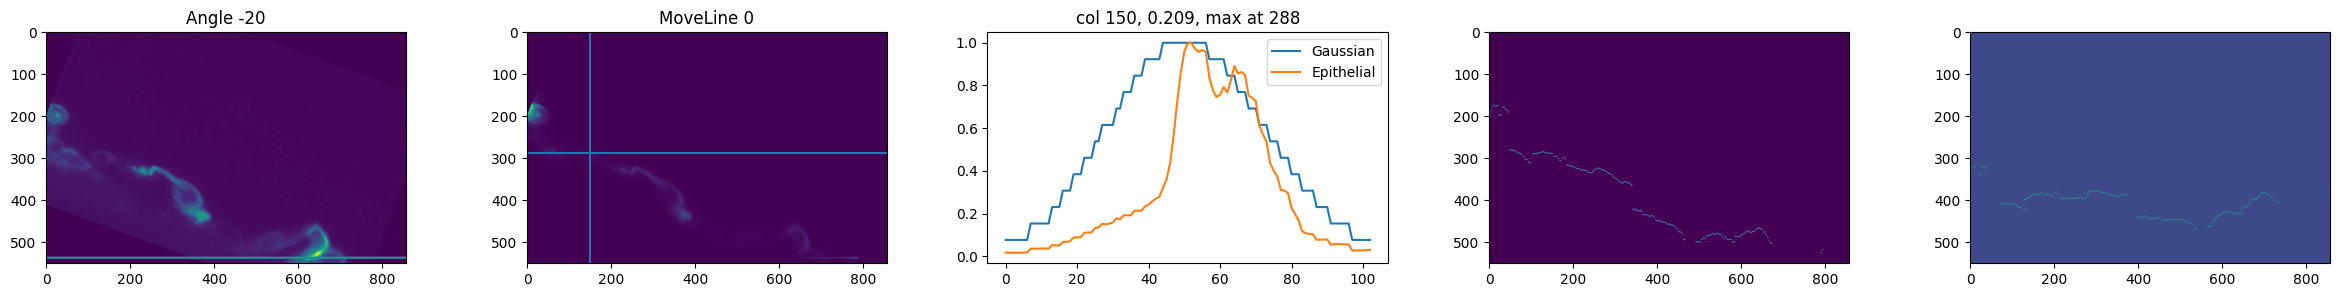

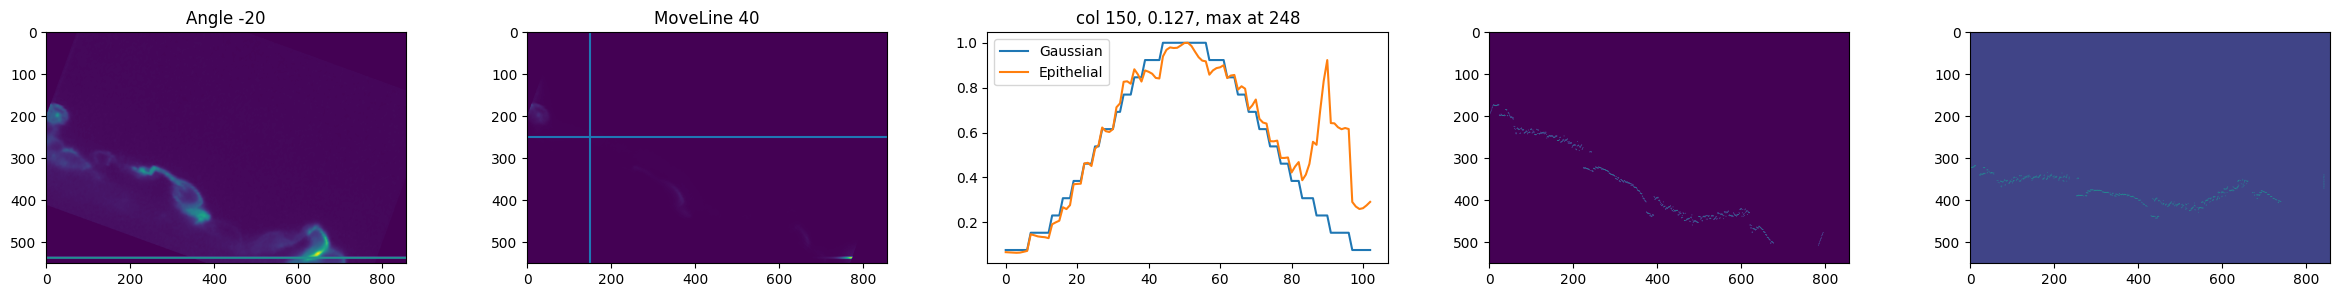

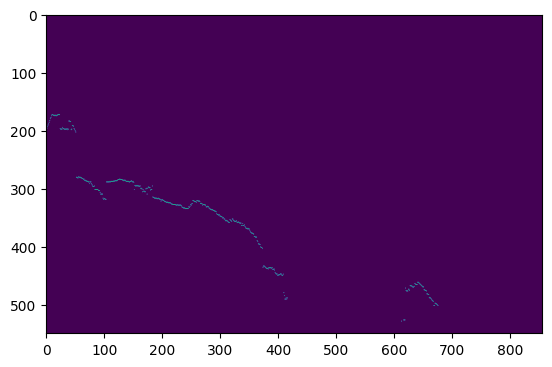

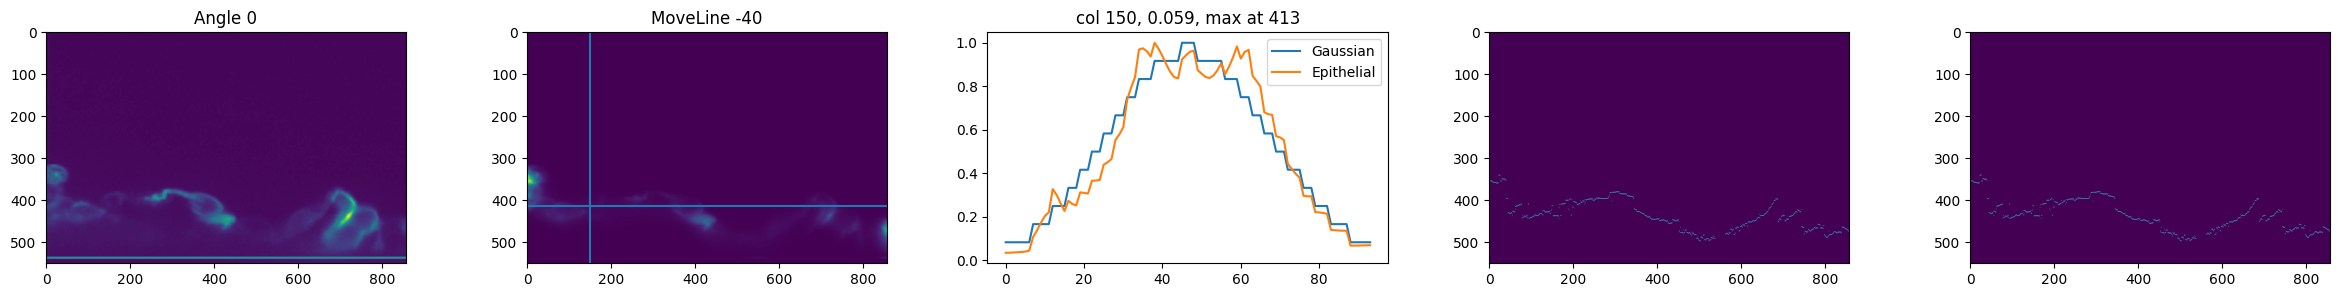

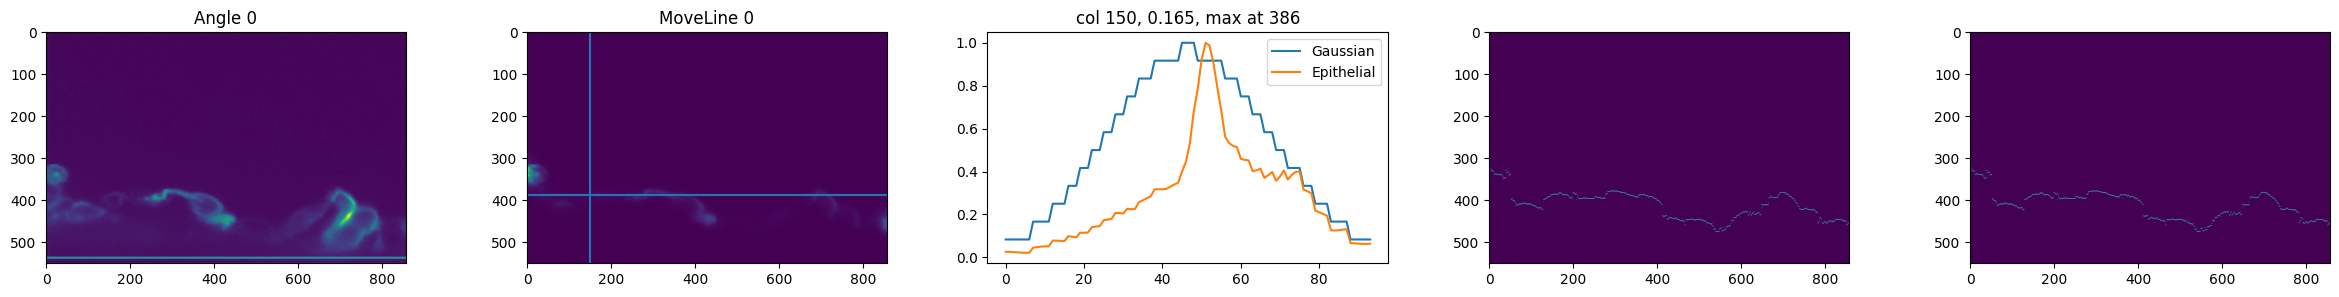

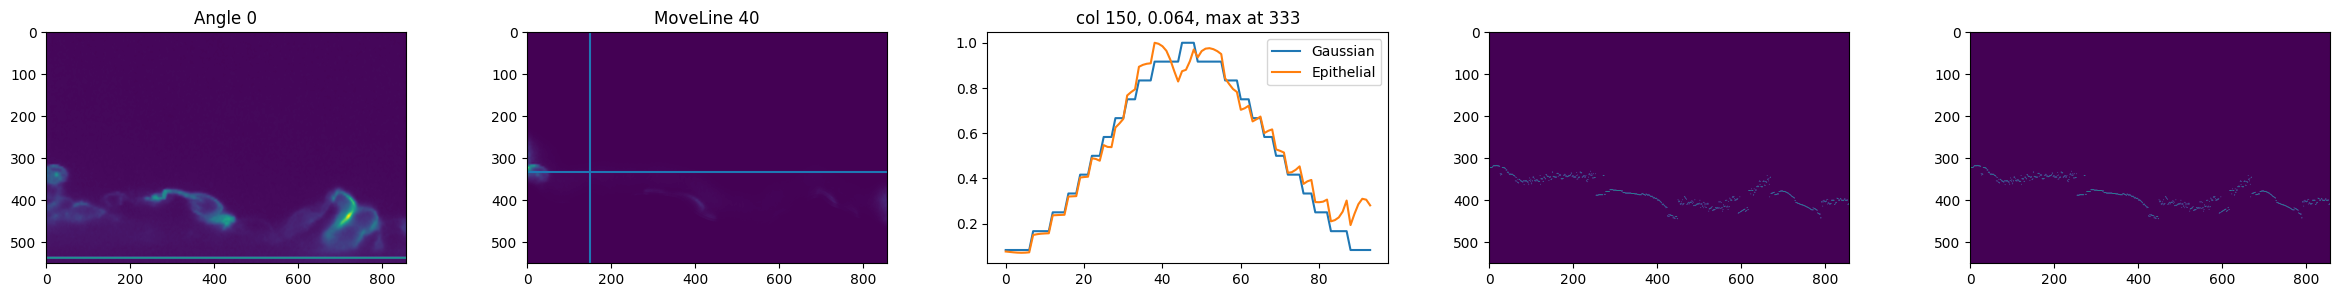

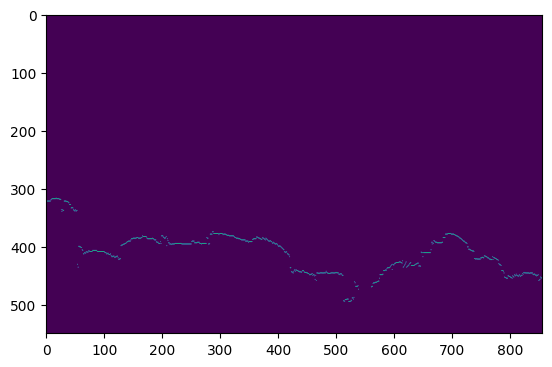

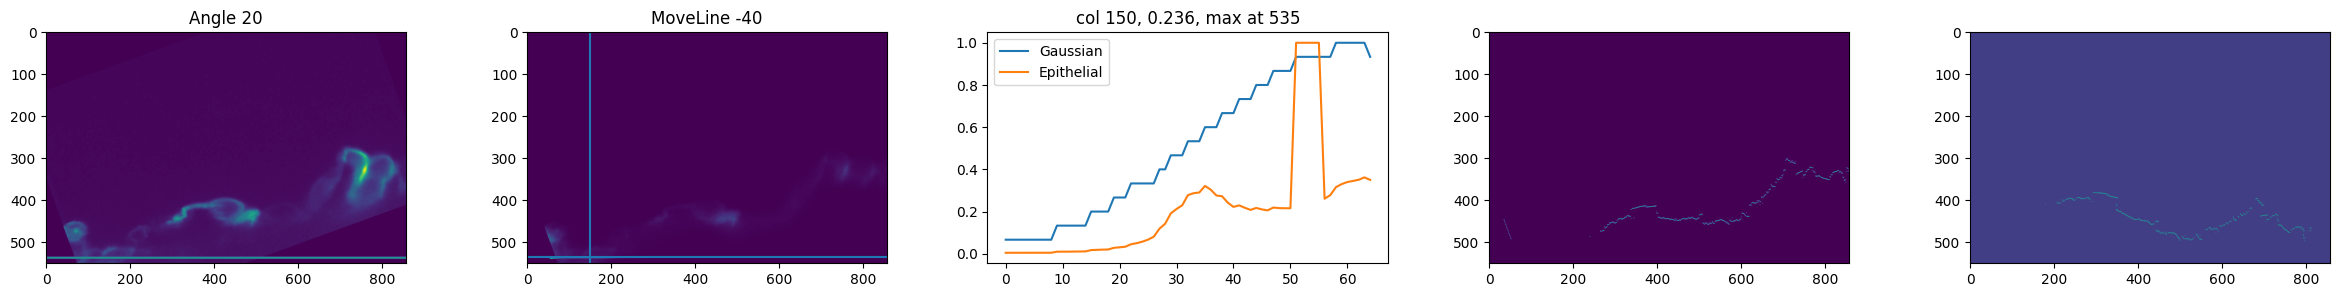

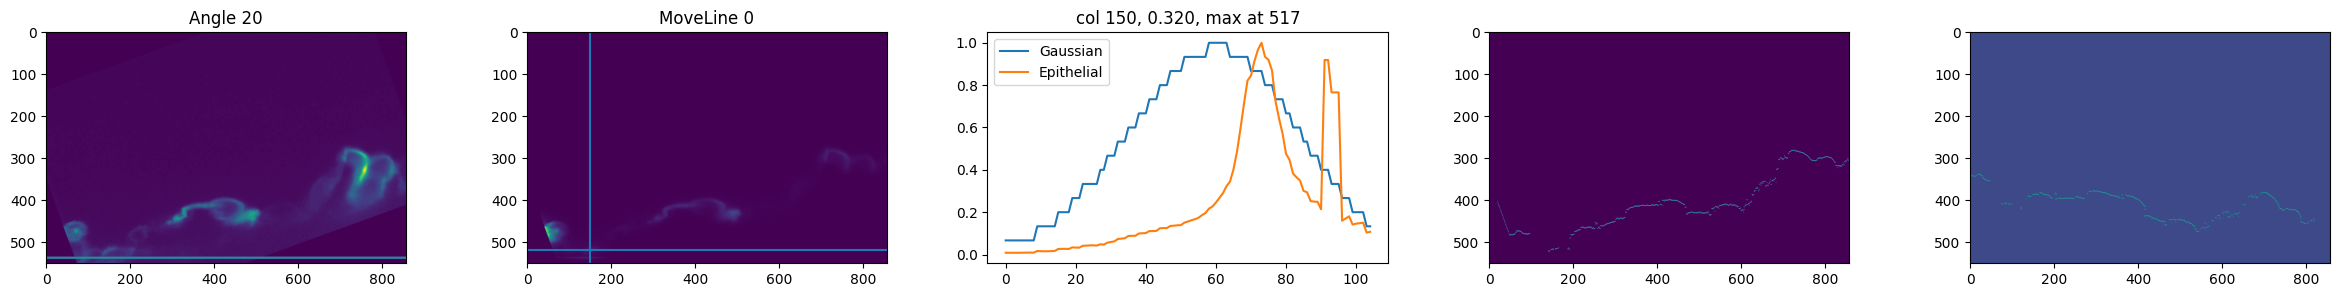

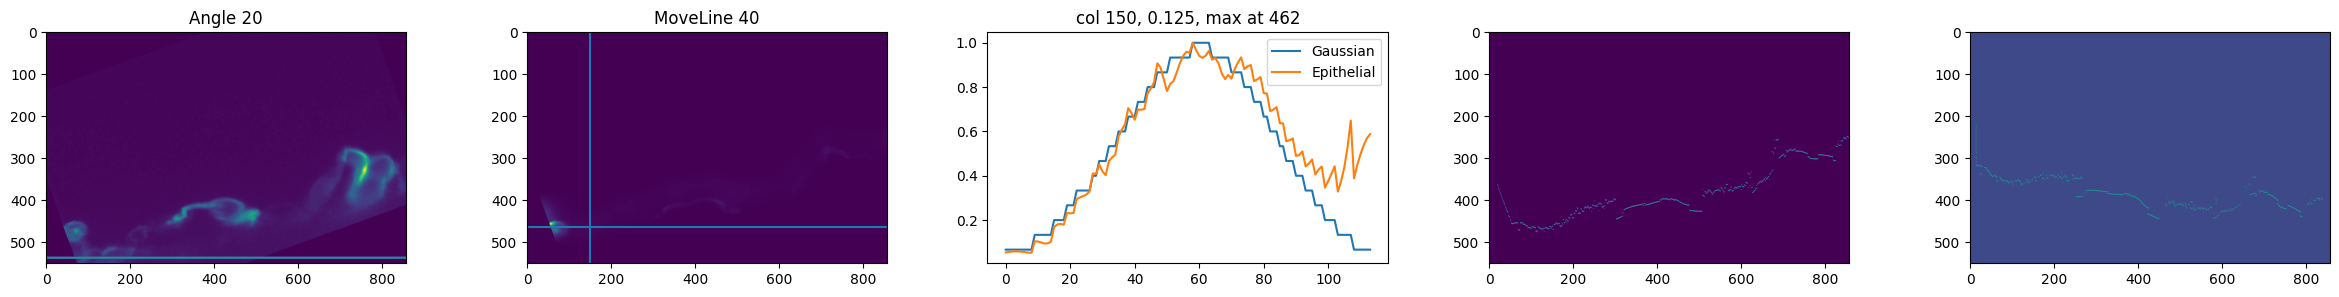

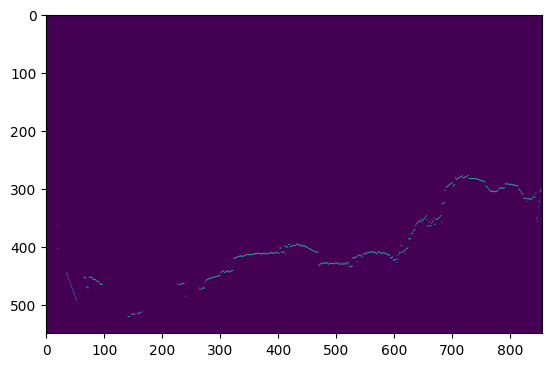

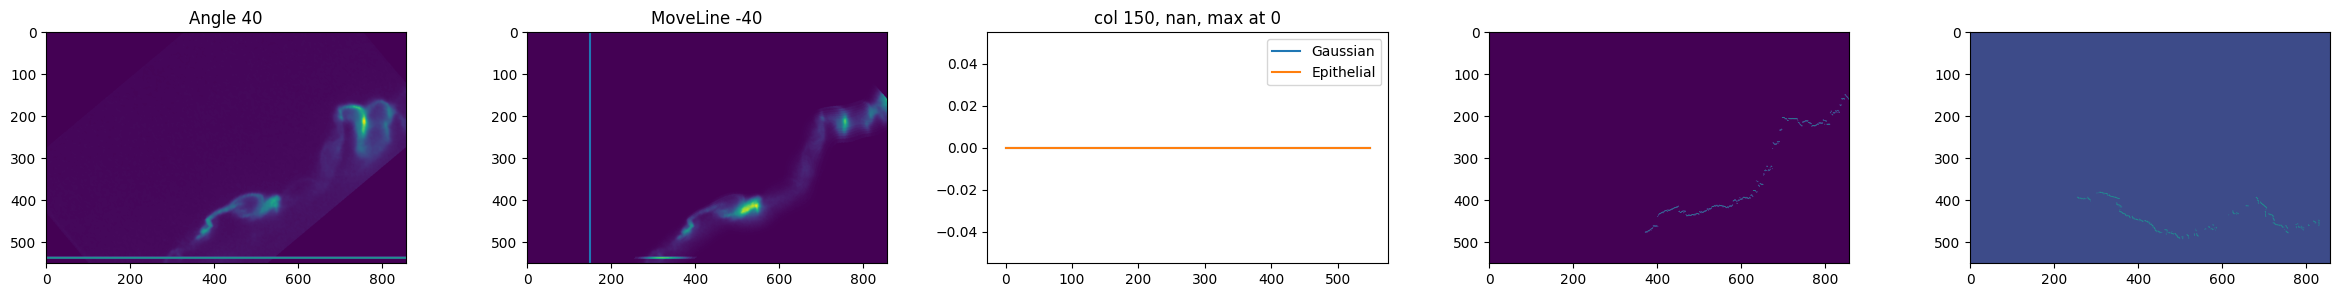

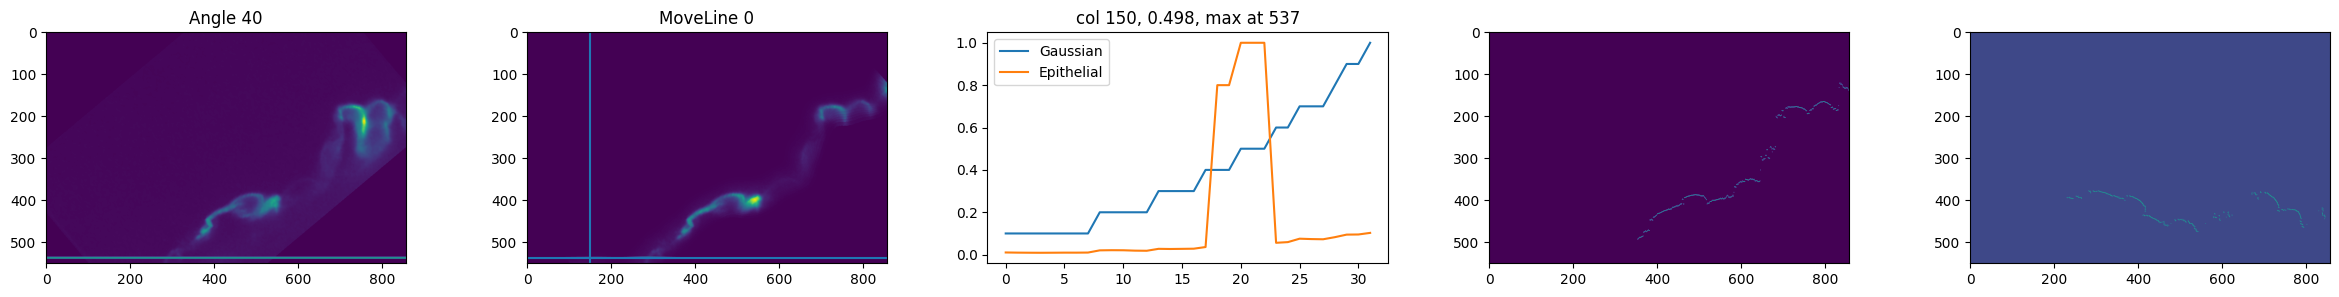

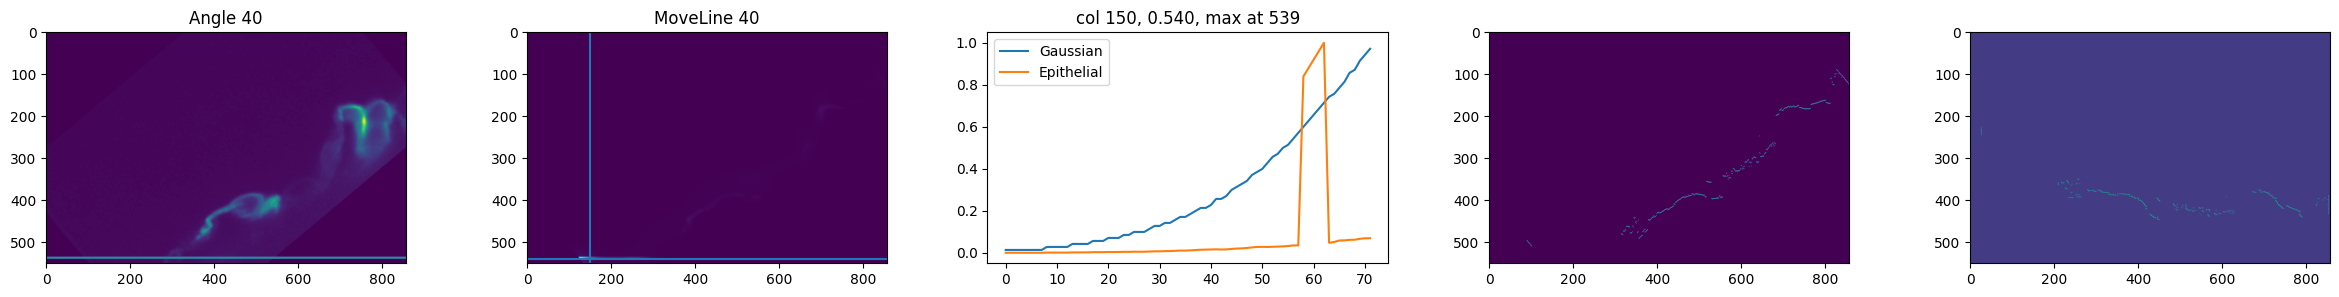

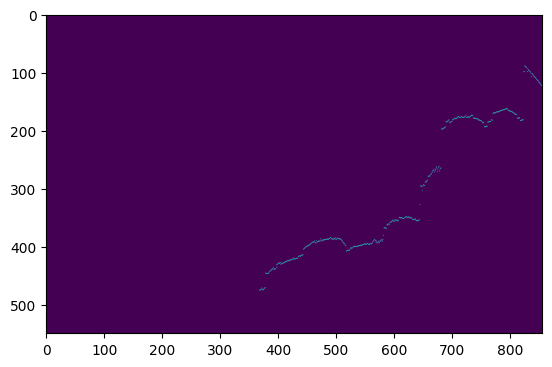

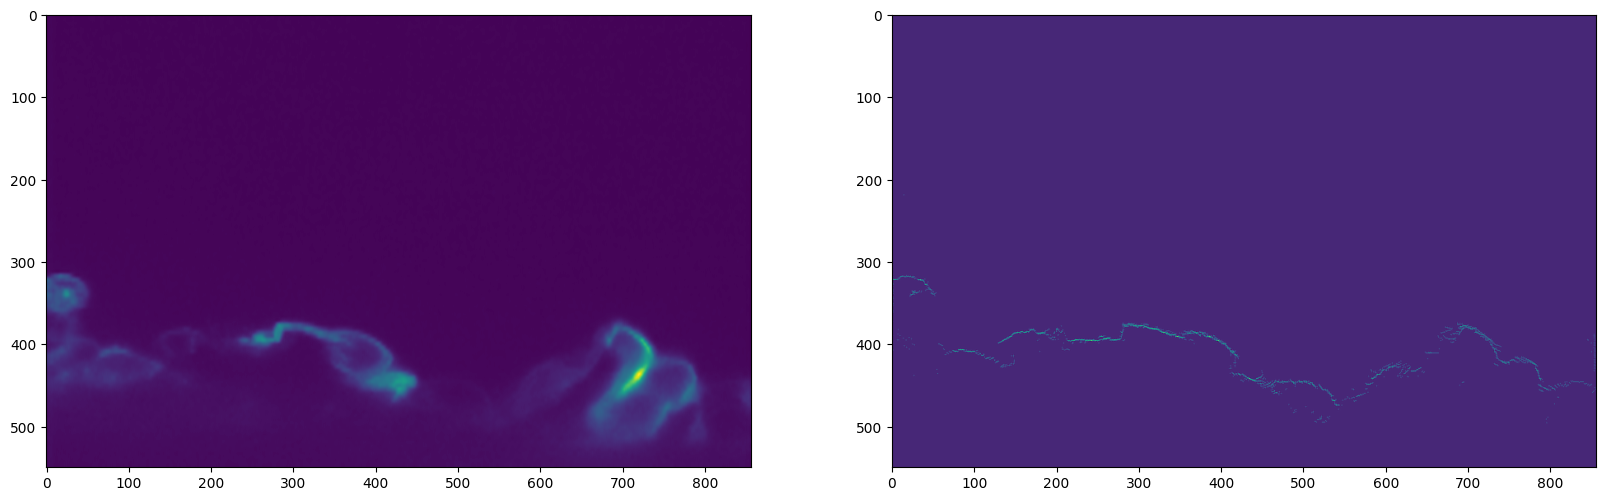

In [11]:
y = 410

angle = 40
angles = [i for i in range(-angle, angle+1, 20)]

moveLine = 40
moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

# angles = [0]

total_apical = fucking_apical(image_r[y], gaussian_top_r[y], angles, moveLines, margin_cut=20, plots=True);

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_r[y])
plt.subplot(122)
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

In [14]:
if os.path.isfile(wd+'_apical_dots_manual_top.tif'):
    total_apical = sk.io.imread(wd+'_apical_dots_manual_top.tif')
else:
    angle = 40
    angles = [i for i in range(-angle, angle+1, 20)]

    moveLine = 40
    moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

    total_apical_r = Parallel(n_jobs=-1)(delayed(fucking_apical)(image_r_i, gaussian_top_r_i, angles, moveLines, margin_cut=5, plots=False) for image_r_i, gaussian_top_r_i in zip(image_r, gaussian_top_r))
    total_apical_r = np.array(total_apical_r)
    total_apical_r[total_apical_r<0] = 0
    total_apical = np.transpose(total_apical_r, axes=(1,2,0))

    tiff.imwrite(wd+'_apical_dots_manual_top.tif', common_functions.normalize_image(total_apical, 255).astype(np.uint8))


if os.path.isfile(wd+'_apical_dots_manual_top_r.tif'):
    total_apical = sk.io.imread(wd+'_apical_dots_manual_top_r.tif')
else:
    angle = 40
    angles = [i for i in range(-angle, angle+1, 20)]

    moveLine = 40
    moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

    image_r = np.transpose(image_r, axes=(2,1,0))
    gaussian_top_r = np.transpose(gaussian_top_r, axes=(2,1,0))

    total_apical_r = Parallel(n_jobs=-1)(delayed(fucking_apical)(image_r_i, gaussian_top_r_i, angles, moveLines, margin_cut=5, plots=False) for image_r_i, gaussian_top_r_i in zip(image_r, gaussian_top_r))
    total_apical_r = np.array(total_apical_r)
    total_apical_r[total_apical_r<0] = 0
    total_apical = np.transpose(total_apical_r, axes=(1,2,0))
    total_apical = np.transpose(total_apical, axes=(0,2,1))


    tiff.imwrite(wd+'_apical_dots_manual_top_r.tif', common_functions.normalize_image(total_apical, 255).astype(np.uint8))
